## Comparision of Ground truth labelled reviews vs predicted topics from 5 algorithms 

In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import pandas as pd 
import numpy as np

# NLP packages
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline   

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import pandas as pd 
import numpy as np

# NLP packages
import re
import nltk
import string
import enchant
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer 
from nltk.corpus import wordnet

In [2]:
label_IBM=pd.read_csv("IBM_labels_topics.csv",encoding = "UTF-8")  #"ISO-8859-1"
#change the order
label_IBM =label_IBM[[ 'Pros', 'Topic_pro','Cons','Topic_con']]
label_IBM.head()

,Pros,Topic_pro,Cons,Topic_con
0,The people at IBM are some of the best you can...,people,As with most consulting companies,culture
1,Great place to work for life,culture,IBM struggles with people outside of london l...,people
2,Working with some very smart and talented peop...,people,making it more difficult to be visible when c...,management
3,It looks good on your resume,company brand,Need to replace Ginni Rommety,management
4,Working from home is allowed,flexibility,- With layoffs every 6-9 months it is hard to ...,job security


In [3]:
pros=list(label_IBM.Pros)
cons=list(label_IBM.Cons)
pro_topic=list(label_IBM.Topic_pro)
con_topic=list(label_IBM.Topic_con)

[Text(0,0.5,'# of Counts'), Text(0.5,0,'Pro Topics')]

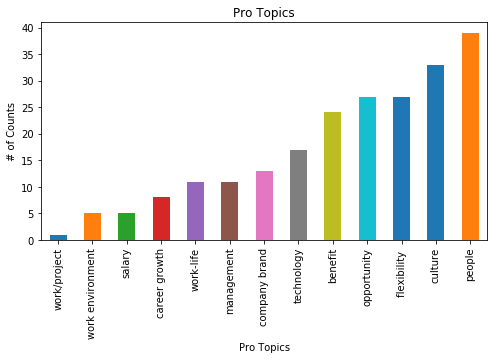

In [4]:
#set(pro_topic)
# overall rating
protopic_plot=label_IBM.Topic_pro.value_counts().sort_values().plot.bar(figsize=(8,4), title="Pro Topics");
protopic_plot.set(ylabel="# of Counts", xlabel="Pro Topics")

[Text(0,0.5,'# of Counts'), Text(0.5,0,'Con Topics')]

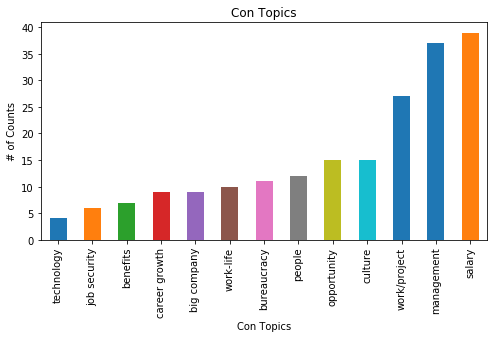

In [5]:
#pd.crosstab(index=label_IBM.index, columns=label_IBM.Topic_con).sum()
contopic_plot=label_IBM.Topic_con.value_counts().sort_values().plot.bar(figsize=(8,4), title="Con Topics");
contopic_plot.set(ylabel="# of Counts", xlabel="Con Topics")

## Ground Truth labeled Cons review 


In [6]:
selected_pro=label_IBM[['Pros','Topic_pro']]
selected_pro.head()

,Pros,Topic_pro
0,The people at IBM are some of the best you can...,people
1,Great place to work for life,culture
2,Working with some very smart and talented peop...,people
3,It looks good on your resume,company brand
4,Working from home is allowed,flexibility


## Ground Truth labeled Cons review 


In [7]:
selected_con=label_IBM[['Cons','Topic_con']]
selected_con=selected_con.dropna()
selected_con.head()
len(selected_con)

,Cons,Topic_con
0,As with most consulting companies,culture
1,IBM struggles with people outside of london l...,people
2,making it more difficult to be visible when c...,management
3,Need to replace Ginni Rommety,management
4,- With layoffs every 6-9 months it is hard to ...,job security


201

## Start to lemmatize the manually labeled reviews 
- then compare with the lemmatized-analyzed reviews

In [8]:
stop_words=stopwords.words('english')
more_stopwords = """etc nan also some just have from it's /via &amp; that they your there this into would can't"""
stop_words += more_stopwords.split()

In [9]:
### check kmeans clustering
d = enchant.Dict("en_US")    # english dictionary

def text_cleaning(text):
    text=text.lower()
    nopunc = [char for char in text if char not in string.punctuation]
    nopunc = ''.join(nopunc)
    tokens=nltk.word_tokenize(nopunc)
    tokens=[token for token in tokens if token.isalpha()]
    tokens=[token for token in tokens if token not in stop_words]
    tagged_tokens= nltk.pos_tag(tokens)
        
    words=filter(lambda x: d.check(x), tokens)
    clean_word=[word for word in words if word not in stop_words]
    return clean_word, tagged_tokens 
def taggedwords(review_list):
    packed_words=[]
    for review in review_list:     # use target list for analysis here is cons
        packed_words.append(text_cleaning(review))
        
    review_words,tagged_tokens=zip(*packed_words)
    return tagged_tokens

wordnet_lemmatizer = WordNetLemmatizer()
def get_wordnet_pos(pos_tag):
    if pos_tag.startswith('J'):
        return wordnet.ADJ
    
    elif pos_tag.startswith('V'):
        return wordnet.VERB
    
    elif pos_tag.startswith('N'):
        return wordnet.NOUN
    
    elif pos_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

In [10]:
# output all lemmatized reviews-pro
manuel_pros_tagged_tokens=taggedwords(selected_pro.Pros)
manuel_pros_lemmatized_words=[] 
for idx, doc in enumerate(manuel_pros_tagged_tokens):
    manuel_pros_lemmatized_words.append([wordnet_lemmatizer.lemmatize(word, get_wordnet_pos(tag)) for (word, tag) in doc])
len(manuel_pros_lemmatized_words)

manuel_pros_lemmatized_text=[" ".join(item) for item in manuel_pros_lemmatized_words]

222

In [11]:
# add lemmatized reviews to the dataframe (manually labeled reviews)
selected_pro['lemmatized_pro']=manuel_pros_lemmatized_text
selected_pro.head()

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,Pros,Topic_pro,lemmatized_pro
0,The people at IBM are some of the best you can...,people,people ibm best work consult industry knowledg...
1,Great place to work for life,culture,great place work life
2,Working with some very smart and talented peop...,people,work smart talented people interest challenge ...
3,It looks good on your resume,company brand,looks good resume
4,Working from home is allowed,flexibility,work home allow


## Create function to calculate the accuracy from Pros:
manually label review vs. 
1. K-Means
2. NMF
3. LDA(sklearn)
4. LDA(gensim)
5. doc2vec

In [12]:
def pro_accuracy(file):
    pro=pd.read_csv(file,encoding = "UTF-8") 
    pro_pred=pro.loc[pro['pro_text'].isin(selected_pro['lemmatized_pro'])]
    pro_pred=pro_pred.drop(pro_pred.columns[0], axis=1)
    pro_pred=pro_pred.drop(pro_pred.columns[1], axis=1)
    pro_pred=pro_pred.drop_duplicates()
    
    # mapping the reviews from 2 dataframes:
    mapping = dict(selected_pro[['lemmatized_pro', 'Topic_pro']].values) 
    pro_pred['topic'] = pro_pred.pro_text.replace(mapping) 

    accuracy=sum(pro_pred.pro_topic==pro_pred.topic)/len(pro_pred)
    
    return accuracy

In [14]:
# output 
pro_out=[pro_accuracy("Pros_IBM_clustering.csv"),pro_accuracy('Pros_IBM_NMF.csv'),\
         pro_accuracy('Pros_IBM_LDA.csv'),pro_accuracy('Pros_IBM_LDA_gensim_unigram.csv'),\
         pro_accuracy('Pros_IBM_doc2vec.csv')]


algorithm=['3-round k-means','NMF','LDA-sklearn','LDA-gensim','doc2vec']

#algorithm_comparision_pro=pd.DataFrame(zip(algorithm,pro_out),columns=['Algorithm','Accuracy'])


/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2856: DtypeWarning: Columns (1,2,3) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


In [15]:
algorithm_comparision_pro=pd.DataFrame(list(zip(algorithm,pro_out)),columns=['Algorithm','Accuracy'])
algorithm_comparision_pro

,Algorithm,Accuracy
0,3-round k-means,0.279188
1,NMF,0.294416
2,LDA-sklearn,0.157360
3,LDA-gensim,0.223881
4,doc2vec,0.028851


## Create function to calculate the accuracy from Cons:
manually label review vs. 
1. K-Means
2. NMF
3. LDA(sklearn)
4. LDA(gensim)
5. doc2vec

In [16]:
# output all lemmatized reviews-cons
manuel_cons_tagged_tokens=taggedwords(selected_con.Cons)

manuel_cons_lemmatized_words=[] 
for idx, doc in enumerate(manuel_cons_tagged_tokens):
    manuel_cons_lemmatized_words.append([wordnet_lemmatizer.lemmatize(word, get_wordnet_pos(tag)) for (word, tag) in doc])
len(manuel_cons_lemmatized_words)

manuel_cons_lemmatized_text=[" ".join(item) for item in manuel_cons_lemmatized_words]

201

In [17]:
selected_con['lemmatized_con']=manuel_cons_lemmatized_text
selected_con.head()

,Cons,Topic_con,lemmatized_con
0,As with most consulting companies,culture,consult company
1,IBM struggles with people outside of london l...,people,ibm struggle people outside london location
2,making it more difficult to be visible when c...,management,make difficult visible connect others community
3,Need to replace Ginni Rommety,management,need replace ginni rommety
4,- With layoffs every 6-9 months it is hard to ...,job security,layoff every month hard stay motivate focus


In [18]:
def con_accuracy(file):
    con=pd.read_csv(file,encoding = "UTF-8") 
    con_pred=con.loc[con['con_text'].isin(selected_con['lemmatized_con'])]
    con_pred=con_pred.drop(con_pred.columns[0], axis=1)
    con_pred=con_pred.drop(con_pred.columns[1], axis=1)
    con_pred=con_pred.drop_duplicates()
    
    # mapping the reviews from 2 dataframes:
    mapping = dict(selected_con[['lemmatized_con', 'Topic_con']].values) 
    con_pred['topic'] = con_pred.con_text.replace(mapping) 

    accuracy=sum(con_pred.con_topic==con_pred.topic)/len(con_pred)
    
    return accuracy

In [19]:
# output 
con_out=[con_accuracy("Cons_IBM_clustering.csv"),con_accuracy('Cons_IBM_NMF.csv'),\
         con_accuracy('Cons_IBM_LDA.csv'),con_accuracy('Cons_IBM_LDA_gensim_unigram.csv')]


algorithm_con=['3-round k-means','NMF','LDA-sklearn','LDA-gensim']


In [20]:
algorithm_comparision_con=pd.DataFrame(list(zip(algorithm_con,con_out)),columns=['Algorithm','Accuracy'])
algorithm_comparision_con

,Algorithm,Accuracy
0,3-round k-means,0.200000
1,NMF,0.189474
2,LDA-sklearn,0.094737
3,LDA-gensim,0.137056
